Notebook part of TFM Carlos Toro Peñas
============================

--- 

Analysis of 2dFGRS several correlation function estimators
-----------------------------------------------------

---


This notebook is an extension inpired by a practical exercise shown in the Python matter over the DataSience master degree.
We have choosen the 2dFGRS catalog intstead the SDSS one the LRG Sample, requires a lot of resources and APIs usage in order to load the FITS files.

Load data:

In [2]:
import pandas as pd
import os
from scipy.integrate import quad


# Enable Copy-on-Write for all subsequent operations
pd.options.mode.chained_assignment = None
dataset = '2dFGRS'
#dataset = 'SDSS'
base_folder = os.getenv('PROJECT_TFM')
file = base_folder+'\\data\\2dfgrs\\2dfgrs-valid.csv'
min_redsifth = 0.0
max_redsifth = 0.28
ra_min = 0.0
ra_sup = 30
dec_min = -30.0
dec_sup = -27.0
print(file)
data = pd.read_csv(file)
data


C:\Users\Carlos\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


C:\desarrollo\astro\tfm\data\2dfgrs\2dfgrs-valid.csv


,GAL_ID,ra,dec,x,y,z,redshift,dist,GROUP_ID
0,2,3.627292,-32.966861,0.099988,0.006339,-0.064981,0.1229,0.119417,12097
1,3,3.586292,-32.388000,0.085393,0.005352,-0.054273,0.1038,0.101322,542
2,5,3.608000,-32.711528,0.084924,0.005355,-0.054652,0.1036,0.101132,4846
3,6,3.612542,-32.862444,0.106340,0.006714,-0.068832,0.1308,0.126850,4847
4,7,3.613417,-33.013278,0.089646,0.005661,-0.058362,0.1099,0.107120,1462
...,...,...,...,...,...,...,...,...,...
104907,332683,218.192917,-2.104833,-0.043573,-0.034280,-0.002038,0.0562,0.055478,12096
104908,332688,218.184250,-2.088833,-0.043808,-0.034454,-0.002033,0.0565,0.055770,12096
104909,332689,218.172000,-2.404389,-0.091945,-0.072281,-0.004911,0.1204,0.117058,78706
104910,332691,218.189667,-2.685111,-0.031195,-0.024539,-0.001861,0.0401,0.039733,78707


Data transformation and change units:

In [3]:
import math


H0 = 70 # Hubble constanst
def parse_distance_megaparsecs(d):
    '''
    Parse raw distances to h-1Mpc
    #977.8 coefficent for converting 1/H into Gyr (Hubble time)
    (H0/100) * d * 977.8 * 1000 /(3.262*H0)  
    '''
    return d * 977.8 * 10 /(3.262) 

data_sample = data[(data['ra'] <= ra_sup) & (data['ra'] >= ra_min) 
                & (data['dec'] >= dec_min) & (data['dec'] <= dec_sup)
                & (data['redshift'] >= min_redsifth) 
                & (data['redshift'] <= max_redsifth)]
#calculate the actual bounds
min_redsifth = data_sample['redshift'].min()
max_redsifth = data_sample['redshift'].max()
ra_min = data_sample['ra'].min()
ra_sup = data_sample['ra'].max()
dec_min = data_sample['dec'].min()
dec_sup = data_sample['dec'].max()
#Convert distances to h-1 MP
#data_sample['dist'] = data_sample['dist'].apply(parse_distance_megaparsecs)
#data_sample['x'] = data_sample['x'].apply(parse_distance_megaparsecs)
#data_sample['y'] = data_sample['y'].apply(parse_distance_megaparsecs)
#data_sample['z'] = data_sample['z'].apply(parse_distance_megaparsecs)
data_sample.loc[:, 'dist'] = data_sample['dist'].apply(parse_distance_megaparsecs)
data_sample.loc[:, 'x'] = data_sample['x'].apply(parse_distance_megaparsecs)
data_sample.loc[:, 'y'] = data_sample['y'].apply(parse_distance_megaparsecs)
data_sample.loc[:, 'z'] = data_sample['z'].apply(parse_distance_megaparsecs)
max_dist = max(data_sample['dist'])
min_dist = 0

data_sample.shape

(6677, 9)

In [4]:
data_sample

,GAL_ID,ra,dec,x,y,z,redshift,dist,GROUP_ID
15829,63517,3.492083,-27.383139,384.675769,23.474428,-199.624039,0.1500,434.023332,1062
15830,63518,3.500875,-27.775806,371.713808,22.740688,-196.147943,0.1453,420.906533,22356
15831,63519,3.488333,-27.570861,240.119424,14.637257,-125.608677,0.0925,271.383726,22357
15832,63523,3.499333,-28.259111,317.439344,19.411715,-170.950106,0.1240,361.065770,22358
15833,63525,3.476083,-27.981528,220.974652,13.422806,-117.619335,0.0853,250.687607,2857
...,...,...,...,...,...,...,...,...,...
52775,155422,25.744375,-27.075167,359.485839,173.351884,-204.011646,0.1551,448.220588,45593
52778,155431,25.704667,-27.116333,309.466336,148.967134,-175.877834,0.1328,385.867377,45596
52789,155454,25.550375,-27.104417,221.410216,105.846310,-125.606365,0.0940,275.686205,45606
52794,155462,25.491250,-27.037917,260.218555,124.069107,-147.127692,0.1108,323.656295,45611


In [5]:
data_sample['dist'].max()

571.5962818984084

Generate a mock catalog to generate a Possion distribution over the space $\mathbb{R}^3$. Note that we have to take the cube of radius:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Foereach dV we get the same number of galaxies.
def ro_t(x):
    """ returns the result of x^3/3 """
    return (x**3)*(1/3)


# Function to convert to radians the angles
def to_radians(angle):
    return angle * math.pi / 180


def simulateCatalog(limits, n_gal, plotRho = False):
    """A simulated catalogue of n_gal galaxies is returned in the given limits
    
       Args:
         limits: (:obj:`dict`): with keys "Dist_min", "Dist_max", "dec_min","dec_max","ra_min","ra_max"
         n_gal:  (:obj:`int`)
         
       Optional Args:
         plotRho: (:obj:`boolean`): Returns plot to see distribution of rho. 
                  
       Retruns:
         pos_cat: (:obj:`numpy array` with shape n_gal x 3): position in cartesian coordinates of the n_gal galaxies
    
    """
    if not isinstance(limits, dict):
        print('Input must by a dictionary')
        return False
    else:
        if "dist_min" not in limits or "dist_max" not in limits:
             raise AssertionError('distMin and distMax keys must be given')
        if "dec_min" not in limits or  "dec_max" not in limits:
             raise AssertionError('dec_min and dec_max keys must be given')
        if "ra_min" not in limits or "ra_max" not in limits:
             raise AssertionError('ra_min and ra_max keys must be given')
            
        dist_min = limits["dist_min"] 
        dist_max =  limits["dist_max"]
           
        ro3 = np.random.uniform(low=ro_t(dist_min),
                        high=ro_t(dist_max), size=n_gal)  
        dec = np.random.uniform(low=limits["dec_min"],
                        high=limits["dec_max"], size=n_gal)
        ra = np.random.uniform(low=limits["ra_min"],
                        high=limits["ra_max"], size=n_gal)

        ro = (3*ro3)**(1/3)
        
        
        if plotRho:
            _ = plt.hist(ro)  # ( _ = added to avoid unnecesary text with plot info )
            plt.xlabel(r'$\rho$')
            plt.ylabel('Number of galaxies')

        # Again, cartesian coords and group in vectors
        x_cat = ro * np.cos(to_radians(dec)) * np.cos(to_radians(ra))
        y_cat = ro * np.cos(to_radians(dec)) * np.sin(to_radians(ra))
        z_cat = ro * np.sin(to_radians(dec))
        pos_cat = np.column_stack((x_cat, y_cat, z_cat))
        
        return pos_cat 
        
limits = {'ra_min': ra_min, 'ra_max': ra_sup,
          "dec_min": dec_min, "dec_max": dec_sup,
          "dist_min": min_dist, "dist_max": max_dist}

p_cat = simulateCatalog(limits, len(data_sample), plotRho = False)
print("RA  limits: {}, {}".format(ra_min, ra_sup))
print("DEC limits: {}, {}".format(dec_min, dec_sup))
print("DIS limits: {}, {}".format(min_dist, max_dist))        
       

RA  limits: 0.0015416666666666, 29.994666666666667
DEC limits: -29.999333333333333, -27.0
DIS limits: 0, 571.5962818984084


Plot the simulated catalog in space $\mathbb{R}^3$

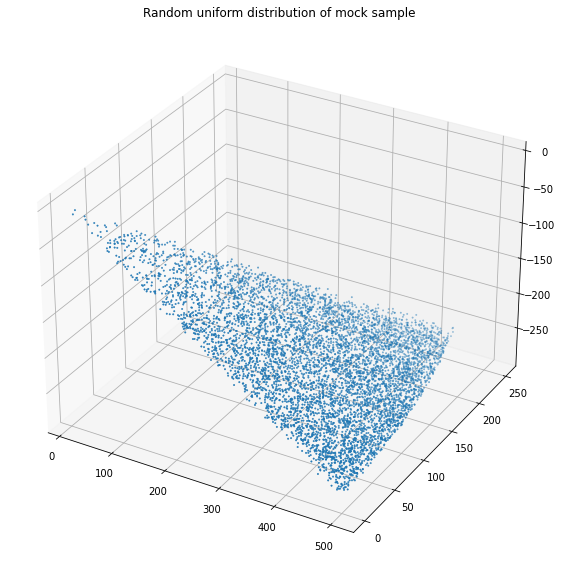

In [7]:
def plot_data_points(x, y, z, title):
    """Plot some points in R^3 space
    Args:
         x, y, z: Coordinates in spaceto be plotted
         Title:  "Title for the chart"
    """
            
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    plt.title(title)
    ax.scatter(x, y, z, s=2, linewidth=0.5)
    plt.show()

xx = list()
yx = list()
zx = list()
for p in p_cat:
    xx.append(p[0])
    yx.append(p[1])
    zx.append(p[2])
plot_data_points(xx, yx, zx, "Random uniform distribution of mock sample")

 Plot data_sample in space $\mathbb{R}^3$

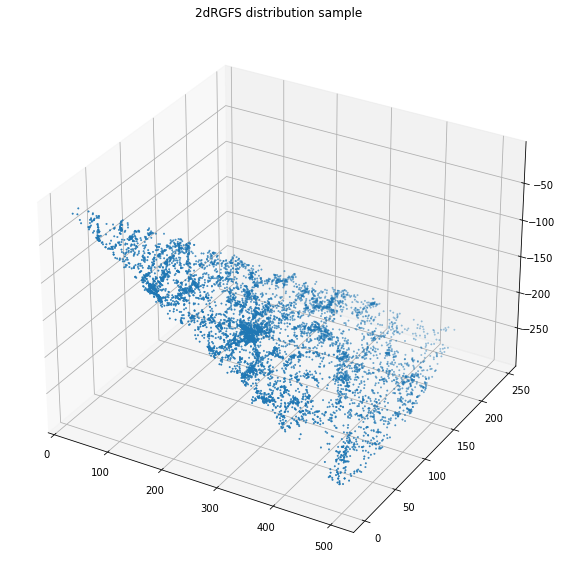

In [8]:
plot_data_points(data_sample['x'], data_sample['y'], data_sample['z'], "2dRGFS distribution sample")

Next step consists in use the theory to calculate the correlation function over different estimators: Natural, Hamilton, David and Peebels and Landy and Szalay.
Note the use of KDTree(data_coords) and KDTree(mock_coords). 

Take into account following considerations:

**Normalization:** The code uses $N(N-1)$ for $DD$ and $RR$ because we are looking at pairs within the same catalog. For $DR$, it uses $N_d \cdot N_r$ because every data point is compared against every random point.

**Computational Efficiency:** Using scipy.spatial.KDTree is significantly faster than a brute-force $O(N^2)$ distance matrix, especially for large datasets common in astronomy or molecular dynamics. Take a look at https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html

Wall time: 33.6 s


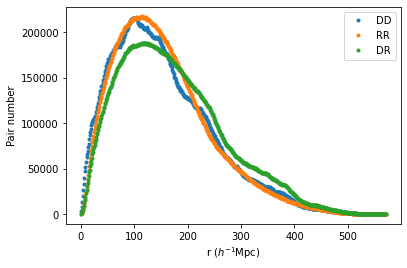

In [9]:
%%time
import numpy as np
from scipy.spatial import KDTree

def calculate_hamilton_estimator(data_coords, random_coords, bins, show_plot):
    """
    Calculates the Hamilton estimator for the two-point correlation function.
    
    Parameters:
    - data_coords: (N, 3) array of data point coordinates.
    - random_coords: (M, 3) array of random point coordinates.
    - bins: array of bin edges for distances.
   
    Returns:
    - xi: The Hamilton estimator for each bin.
    - bin_centers: The midpoint of each distance bin.
    """
    # KDETree creation
    tree_data = KDTree(data_coords)
    tree_random = KDTree(random_coords)

    dd_counts = tree_data.count_neighbors(tree_data, bins)
    rr_counts = tree_random.count_neighbors(tree_random, bins)
    dr_counts = tree_data.count_neighbors(tree_random, bins)

    DD = np.diff(dd_counts)
    RR = np.diff(rr_counts)
    DR = np.diff(dr_counts)

    # 4. Normalize the counts
    # DD and RR need to subtract the self-matches (distance=0) which count_neighbors includes
    # However, since we diff, the first bin (0 to r1) handles this. 
    # Usually, we exclude the 0-distance pairs for DD and RR.
    N_d = len(data_coords)
    N_r = len(random_coords)
    
    #All data are normalized: same length
    norm_dd = DD / (N_d * (N_d - 1))
    norm_rr = RR / (N_r * (N_r - 1))
    norm_dr = DR / (N_d * N_r)
    xis = list()
    title = ""
    for i in list(range(4)):
        # We use a small epsilon to avoid division by zero
        # Hamilton
        if i==1:
            xi = (norm_dd * norm_rr) / (norm_dr**2 + 1e-15) - 1
            title = 'Hamilton'
        # Natural
        if i==0:
            xi = norm_dd / (norm_rr + 1e-15) - 1
            title = 'Natural'
        # David and Peebels
        if i == 2:
            xi = norm_dd / (norm_dr + 1e-15) - 1
            title = 'David and Peebels'
        # Landy and Szalay
        if i == 3:
            xi = (norm_dd - 2 * norm_dr + norm_rr) / (norm_rr + 1e-15)
            title = 'Landy and Szalay'
        xis.append({'values': xi, 'title': title})
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    if show_plot:
        plt.plot(bin_centers, DD, '.', label='DD')
        plt.plot(bin_centers, RR, '.', label='RR')
        plt.plot(bin_centers, DR, '.', label='DR')
        plt.xlabel(r'r ($h^{-1}$Mpc)')
        plt.ylabel('Pair number')
        plt.legend()

    return xis, bin_centers

dr = 1
# Generate coordinates vector
p = np.column_stack((np.array(data_sample["x"]),
                 np.array(data_sample["y"]), np.array(data_sample["z"])))

# Bins gneration
bins = np.arange(min_dist, max_dist, dr)  # generate distance intervals.

correlation, centers = calculate_hamilton_estimator(p, p_cat, bins, True)


We finally plot the estimators results:

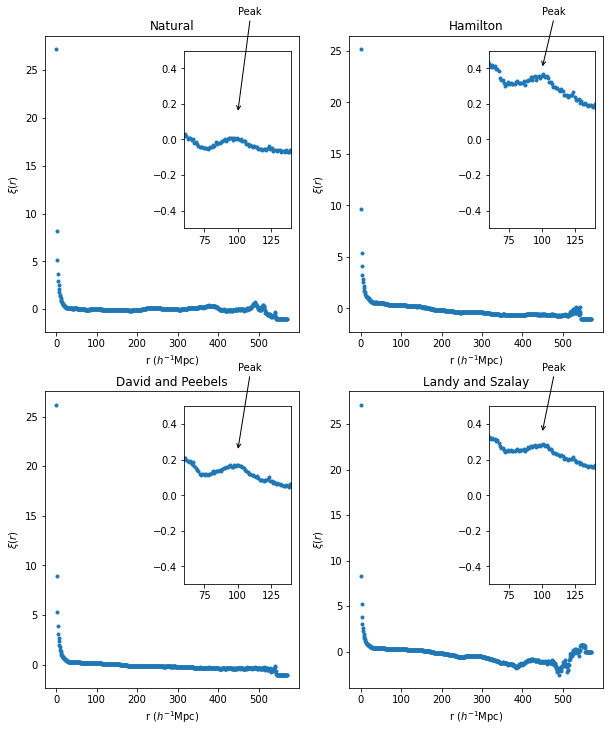

In [10]:
r = centers 

fig, ax = plt.subplots(2, 2, figsize=[10, 12])
index = 0
sizes = (0.15, 0.40, 0.25, 0.35)
for i in list(range(2)):
    for j in list(range(2)):
        current = correlation[index]
        ax[i, j].plot(r, current['values'], '.')
        ax[i, j].set_xlabel("r ($h^{-1}$Mpc)")
        ax[i, j].set_ylabel(r"$\xi(r)$")
        ax[i, j].set_title(current['title'],)

        axins = ax[i, j].inset_axes([0.55, 0.35, 0.42, 0.60])
        axins.plot(r, current['values'], '.')
        # sub region of the original image
       # x1, x2, y1, y2 = 50, 140, corrs[index][3], 0.5
        x1, x2, y1, y2 = 60, 140, -0.5, 0.5
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        _ = axins.annotate("Peak ",
                   xy=(100, sizes[index]), xycoords='data',
                   xytext=(100, 0.7), textcoords='data',
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3")
                   )
        index = index + 1 

These peaks close to the 100 $h^{-1}$Mpc (1$h^{-1}$Mpc = 0.7Mpc ) are explained by the cosmological model and is an already known feature of the Cosmic Background Radiation (CBR) called Baryonic Acoustic Oscillations (BAOs).

Globally speaking, the probability to find galaxies diminsh with the distance, this is expected, but around 100 $h^{-1}$Mpc we see that density grows again until a certain point, producing a peak or "bump" of density.

Such peak have to do with the fluctuations produced in the early universe, the explanation is as follows:

In the early Universe, prior to the recombination (decoupling) epoch, baryonic matter and radiation were tightly coupled in a hot, dense plasma. While gravity acted to compress this plasma into primordial density seeds, the intense radiation pressure acted as a restoring force, pushing the baryonic matter outward. 

These opposing forces created spherical acoustic pressure waves that traveled through the plasma. Crucially, Dark Matter, which does not interact with radiation, did not experience this outward pressure. Instead, it remained at the center of the original perturbation, governed only by gravity. This created a separation: a central concentration of dark matter and a spherical shell of baryonic matter moving outward at approximately 57% of the speed of light. 

At approximately 380,000 years after the Big Bang (the decoupling era), the Universe cooled sufficiently for neutral atoms to form. At this point, the photons escaped (forming the Cosmic Microwave Background), and the sound wave was suddenly "frozen" in place. This left a characteristic shell of baryonic matter at a fixed distance—the sound horizon—relative to the central dark matter peak. 

Over billions of years, gravity pulled more matter into both the central peak and the spherical shell. As the Universe expanded, this "fingerprint" persisted in the large-scale structure. Today, this manifests as a statistically significant excess of galaxy pairs separated by approximately $150 \text{ Mpc}$ (or $100 \text{ } h^{-1}\text{Mpc}$), appearing as the BAO peak in our 2PCF analysis.

In [11]:
max_dist

571.5962818984084